In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.decomposition import PCA
import seaborn as sns
from tensorflow import keras
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
classes = np.unique(y_train)
nClasses = len(classes)
print('Number of Outputs: ', nClasses)
print('Number of Output Classes: ', classes)

Number of Outputs:  10
Number of Output Classes:  [0 1 2 3 4 5 6 7 8 9]


In [ ]:
#plot images from dataset
%matplotlib inline

label_list = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck',
}

plt.figure(figsize = [10,10])

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, '(Label: Frog)')
Text(0.5, 1.0, '(Label: Cat)')


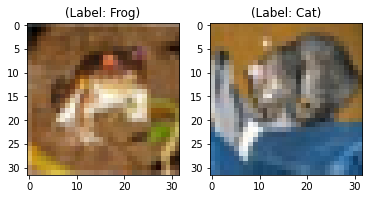

In [ ]:
#display 1st image in training data
plt.subplot(121)
curr_img = np.reshape(x_train[0], (32,32,3))
plt.imshow(curr_img)
print(plt.title("(Label: " + str(label_list[y_train[0][0]]) + ")"))

#display 1st image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test[0], (32,32,3))
plt.imshow(curr_img)
print(plt.title("(Label: " + str(label_list[y_test[0][0]]) + ")"))

In [ ]:
#check max and min values of dataset
np.min(x_train), np.max(x_train)

(0, 255)

In [ ]:
#normalize pixels between 0 and 1
x_train = x_train/255.0
np.min(x_train), np.max(x_train)
x_train.shape

(50000, 32, 32, 3)

In [ ]:
#flatten images
x_train_flat = x_train.reshape(-1,3072)
feat_cols = ['pixel' + str(i) for i in range(x_train_flat.shape[1])]
df_cifar = pd.DataFrame(x_train_flat, columns = feat_cols)
df_cifar['Label'] = y_train
print('Size of Data Frame: {}'.format(df_cifar.shape))

Size of Data Frame: (50000, 3073)


In [ ]:
#reshape dataset and determine number of variance
x_test = x_test/255.0
x_test = x_test.reshape(-1, 32, 32, 3)
x_test_flat = x_test.reshape(-1, 3072)

In [ ]:
pca = PCA(n_components=5)
pca.fit(x_train_flat)
PCA(copy = True, iterated_power = 'auto', n_components = 0.99, random_state = None, svd_solver = 'auto', tol = 0.0, whiten = False)
pca.n_components_

5

In [ ]:
train_img_pca = pca.transform(x_train_flat)
test_img_pca = pca.transform(x_test_flat)

#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)

In [ ]:
#variance of principal components
print('Explained Variation per Principal Component: {}'.format(pca.explained_variance_ratio_))

Explained Variation per Principal Component: [0.2907663  0.11253144 0.06694414 0.03676459 0.03608843]


In [ ]:
train_img_pca[0]

array([-6.40101763,  2.72903876,  1.50171051, -2.95333278, -4.45258051])

In [ ]:
scaler = preprocessing.StandardScaler().fit(train_img_pca)

In [ ]:
x_train_scaled = scaler.transform(train_img_pca)
x_test_scaled  = scaler.transform(test_img_pca)

We are done with the data preprocessing. Now, we can create the priors and model initializations

In [ ]:
prob_theta = np.asarray([0.1]*10) #Since the Gibbs Sampling method converges much harder than Variational Inference method, we set the probs as 1/10 for each cluster and will not update it 

In [ ]:
beta_std = 1
beta_prior = np.random.normal(0, beta_std, (10,5)) #dimension is 10x5, a length-5 beta_k vector for each one of 10 clusters 

In [ ]:
y_train_flat = np.ndarray.flatten(y_train)
y_train_onehot = np.zeros((y_train_flat.size, y_train_flat.max() + 1))
y_train_onehot[np.arange(y_train_flat.size), y_train_flat] = 1

In [ ]:
z_train_prior = np.random.randint(10, size=50000, dtype=int)

Now, we can start the parameter update process

In [ ]:
epochs = 50
beta = beta_prior
z_train = z_train_prior
cluster_num = 10
feature_num = pca.n_components_
data_num = len(x_train)
sig = 1
lamb = 1

In [ ]:
def normalize_one(arr):
  arr = np.asarray(arr)
  total = np.sum(arr)
  return arr/total

In [ ]:
def calc_log_posterior(z_train, beta, x_train_scaled):
  data_num = len(z_train)
  cluster_num = beta.shape[0]
  feature_num = beta.shape[1]
  log_post = 0
  for i in range(data_num):
    log_post += -(np.sum((x_train_scaled[i]-beta[z_train[i]])**2))/(2*sig**2)
  print(log_post)
  return log_post

In [ ]:
def z_sampler(z_index, beta, x_train_scaled):
  cluster_num = beta.shape[0]
  feature_num = beta.shape[1] 
  x_sample = x_train_scaled[z_index]
  x_cond_probs = np.asarray([None]*cluster_num)
  for cluster in range(cluster_num):
    cluster_prob = 0
    for feature in range(feature_num):
      cluster_prob += np.exp(np.sum((x_train_scaled[z_index]-beta[cluster])**2)/(-2*sig**2))
    x_cond_probs[cluster] = cluster_prob
  x_cond_probs = normalize_one(x_cond_probs)
  z_sampled = np.random.choice(cluster_num, p=np.asarray(x_cond_probs, dtype='float64'))
  return z_sampled, x_cond_probs

In [ ]:
def b_sampler(b_index, z_train, x_train_scaled): #b_index is equivalent to k from the lecture notes
  data_num = len(z_train)
  feature_num = len(x_train_scaled[0])
  indeces = [i for i in range(data_num) if z_train[i] == b_index]
  x_indexed = x_train_scaled[indeces]
  x_indexed_mean = np.mean(x_indexed, axis=0)
  nk = len(indeces) #number of x's assigned as y = k (according to z, not the true label y)
  mu_k = (nk/(sig**2))/((nk/(sig**2))+(1/(lamb**2)))*x_indexed_mean
  lamb_k_val = np.sqrt(1/((nk/(sig**2))+(1/(lamb**2))))
  lamb_k = np.asarray([lamb_k_val]*feature_num)
  return np.random.normal(loc=mu_k, scale=lamb_k) #returns updated b_k for a specific cluster k (b_index)

In [ ]:
beta_std_vals = [0.5, 2, 10]
sig_values = [0.5, 2, 10]
lamb_values = [0.5, 2, 10]

epochs = 10
cluster_num = 10
feature_num = pca.n_components_
data_num = len(x_train)
z_train = z_train_prior

In [ ]:
for beta_std in beta_std_vals:
  for sig in sig_values:
    for lamb in lamb_values:
      beta = np.random.normal(0, beta_std, (10,5)) #dimension is 10x5, a length-5 beta_k vector for each one of 10 clusters
      print("beta_std: " + str(beta_std) + ", sig: " + str(sig) +", lamb: " + str(lamb)) 
      for epoch in range(epochs):
        for z_index in range(data_num):
          z_train[z_index] = z_sampler(z_index, beta, x_train_scaled)[0] 
        for cluster in range(cluster_num):
            beta[cluster] = b_sampler(cluster, z_train, x_train_scaled)
        calc_log_posterior(z_train, beta, x_train_scaled)


beta_std: 0.5, sig: 0.5, lamb: 0.5
-317967.01123101794
-287077.3779391262
-275295.11315929354
-268277.7999647387
-262580.20270423556
-257515.49447112196
-252256.54177199097
-247088.51145617687
-243230.11276432098
-241848.71836123956
beta_std: 0.5, sig: 0.5, lamb: 2
-328550.91749527975
-287606.4152735736
-275748.72207892395
-268201.8199284189
-260681.4555724063
-255018.21102845433
-251567.6072685146
-249155.0678023474
-247694.03046869137
-246300.9490368463
beta_std: 0.5, sig: 0.5, lamb: 10
-315309.74946321105
-270011.3156392561
-258872.79027182126
-256087.86579495214
-254619.41806888086
-253695.19605161902
-252837.66258913555
-251817.61377655942
-251265.8052998182
-250256.2026007393
beta_std: 0.5, sig: 2, lamb: 0.5
-30762.13531201074
-31227.334411007578
-31272.484817233777
-31274.09321776634
-31281.145781928568
-31270.187618664422
-31273.900170296427
-31259.415950427912
-31270.541771876502
-31265.42077350731
beta_std: 0.5, sig: 2, lamb: 2
-31079.67412113971
-31252.00361783467
-31255.516

My Gibbs sampling algorithm did not really converge on Cifar-10 Dataset even though I could not find any error in the implementation. That is why, I decided to use Scikit Learn Library to implement LDA on a news headline data set:

In [ ]:
import os
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load Dataset
data = pd.read_csv('abcnews-date-text.csv', error_bad_lines=False);
documents_list= data['headline_text'].tolist()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
documents_list_in = documents_list[:1000000]
documents_list_out = documents_list[1000000:]

In [ ]:
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
train_data_in = tfidf.fit_transform(documents_list_in) 
train_data_out = tfidf.transform(documents_list_out) 

In [ ]:
# Define the number of topics or components
num_components=4

# Create LDA object
model2=LatentDirichletAllocation(n_components=num_components, max_iter = 2)
model4=LatentDirichletAllocation(n_components=num_components, max_iter = 4)
model6=LatentDirichletAllocation(n_components=num_components, max_iter = 6)
model8=LatentDirichletAllocation(n_components=num_components, max_iter = 8)
model10=LatentDirichletAllocation(n_components=num_components, max_iter = 10)

In [ ]:
# Fit SVD model on data
model2.fit(train_data_in)

LatentDirichletAllocation(max_iter=2, n_components=4)

In [ ]:
lda_matrix2 = model2.transform(train_data_in)



In [ ]:
# Get Components 
lda_components2=model2.components_
# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components2):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['interview', 'man', 'police', 'court', 'says', 'jailed', 'new', 'charged', 'drug', 'death']
Topic 1:  ['crash', 'council', 'police', 'says', 'qld', 'new', 'man', 'court', 'govt', 'country']
Topic 2:  ['police', 'man', 'court', 'new', 'business', 'market', 'govt', 'news', 'attack', 'fight']
Topic 3:  ['new', 'police', 'plan', 'govt', 'abc', 'charged', 'farmers', 'weather', 'man', 'help']


In [ ]:
model2.perplexity(train_data_in)

19806.8986356928

In [ ]:
model2.perplexity(train_data_out)

42154.698557842385

In [ ]:
# Fit SVD model on data
model4.fit(train_data_in)

LatentDirichletAllocation(max_iter=4, n_components=4)

In [ ]:
lda_matrix4 = model4.transform(train_data_in)

In [ ]:
# Get Components 
lda_components4=model4.components_
# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components4):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['man', 'police', 'abc', 'crash', 'court', 'killed', 'car', 'govt', 'child', 'accused']
Topic 1:  ['water', 'police', 'new', 'council', 'interview', 'farmers', 'plan', 'govt', 'search', 'wa']
Topic 2:  ['new', 'rural', 'council', 'country', 'health', 'nsw', 'national', 'govt', 'qld', 'says']
Topic 3:  ['man', 'police', 'charged', 'day', 'death', 'new', 'market', 'interview', 'woman', 'court']


In [ ]:
model4.perplexity(train_data_in)

18047.317748728412

In [ ]:
model4.perplexity(train_data_out)

39061.15305092236

In [ ]:
# Fit SVD model on data
model6.fit(train_data_in)

LatentDirichletAllocation(max_iter=6, n_components=4)

In [ ]:
lda_matrix6 = model6.transform(train_data_in)

In [ ]:
# Get Components 
lda_components6=model6.components_
# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components6):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['interview', 'day', 'australia', 'cup', 'win', 'new', 'world', 'says', 'final', 'drug']
Topic 1:  ['man', 'police', 'crash', 'killed', 'court', 'charged', 'death', 'woman', 'missing', 'car']
Topic 2:  ['govt', 'abc', 'water', 'new', 'rural', 'farmers', 'council', 'plan', 'police', 'urged']
Topic 3:  ['new', 'council', 'police', 'plan', 'centre', 'blaze', 'fears', 'water', 'interview', 'home']


In [ ]:
model6.perplexity(train_data_in)

17246.841850688787

In [ ]:
model6.perplexity(train_data_out)

37662.68106757268

In [ ]:
# Fit SVD model on data
model8.fit(train_data_in)

LatentDirichletAllocation(max_iter=8, n_components=4)

In [ ]:
lda_matrix8 = model8.transform(train_data_in)

In [ ]:
# Get Components 
lda_components8=model8.components_
# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components8):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['new', 'power', 'water', 'day', 'closer', 'council', 'final', 'win', 'rain', 'wins']
Topic 1:  ['interview', 'north', 'south', 'new', 'police', 'west', 'australia', 'council', 'aid', 'cup']
Topic 2:  ['man', 'police', 'crash', 'charged', 'car', 'killed', 'missing', 'court', 'murder', 'woman']
Topic 3:  ['govt', 'abc', 'market', 'new', 'rural', 'plan', 'council', 'report', 'rise', 'business']


In [ ]:
model8.perplexity(train_data_in)

16682.95821428011

In [ ]:
model8.perplexity(train_data_out)

36767.57359086032

In [ ]:
# Fit SVD model on data
model10.fit(train_data_in)

LatentDirichletAllocation(n_components=4)

In [ ]:
lda_matrix10 = model10.transform(train_data_in)

In [ ]:
# Get Components 
lda_components10=model10.components_
# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components10):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['police', 'man', 'crash', 'charged', 'car', 'killed', 'missing', 'death', 'woman', 'dies']
Topic 1:  ['health', 'govt', 'new', 'rural', 'child', 'budget', 'says', 'council', 'news', 'funding']
Topic 2:  ['water', 'council', 'new', 'govt', 'plan', 'abc', 'weather', 'says', 'pm', 'report']
Topic 3:  ['interview', 'win', 'cup', 'world', 'court', 'test', 'final', 'guilty', 'murder', 'trial']


In [ ]:
model10.perplexity(train_data_in)

16155.872705848691

In [ ]:
model10.perplexity(train_data_out)

35816.71935787367

In [ ]:
model10_8=LatentDirichletAllocation(n_components=8, max_iter = 10)

In [ ]:
# Fit SVD model on data
model10_8.fit(train_data_in)

LatentDirichletAllocation(n_components=8)

In [ ]:
lda_matrix10_8 = model10_8.transform(train_data_in)

In [ ]:
# Get Components 
lda_components10_8=model10_8.components_
# Print the topics with their terms
terms = tfidf.get_feature_names()

for index, component in enumerate(lda_components10_8):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0:  ['interview', 'win', 'cup', 'final', 'clash', 'tigers', 'open', 'england', 'play', 'title']
Topic 1:  ['man', 'police', 'court', 'charged', 'murder', 'death', 'missing', 'accused', 'charges', 'woman']
Topic 2:  ['iraq', 'killed', 'news', 'day', 'pakistan', 'kills', 'dead', 'troops', 'blast', 'abc']
Topic 3:  ['council', 'govt', 'new', 'plan', 'abc', 'weather', 'union', 'labor', 'says', 'workers']
Topic 4:  ['market', 'prices', 'live', 'rain', 'east', 'share', 'markets', 'price', 'australian', 'firefighters']
Topic 5:  ['interview', 'world', 'asylum', 'new', 'cup', 'wins', 'australia', 'smith', 'seekers', 'league']
Topic 6:  ['water', 'health', 'govt', 'new', 'plan', 'funding', 'boost', 'urged', 'council', 'qld']
Topic 7:  ['crash', 'car', 'dies', 'man', 'fatal', 'accident', 'police', 'driver', 'plane', 'killed']


In [ ]:
model10_8.perplexity(train_data_in)

21103.808072908552

In [ ]:
model10_8.perplexity(train_data_out)

57882.67742064533

In [1]:
import matplotlib.pyplot as plt

In [5]:
perp_in = np.asarray([19806, 18047, 17246, 16682, 16155])
perp_out = np.asarray([42154, 39061, 37662, 36767, 35816])
X = np.asarray([2,4,6,8,10])

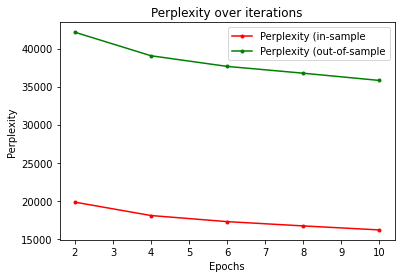

In [11]:
# Plotting both the curves simultaneously
plt.plot(X, perp_in, color='r', label='Perplexity (in-sample', marker ='.')
plt.plot(X, perp_out, color='g', label='Perplexity (out-of-sample', marker ='.')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Perplexity over iterations")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()